# DSCI 572 lecture 5

- introduction to artificial neural networks; backpropagation as reverse-mode differentiation	


In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

Vocabulary:

- supervised, unsupervised
- regression, classification
- deep learning
- (artificial) neural net(work)
- NN, ANN, CNN
- layers
- units, neurons, activations
- hidden, visible
- activation function, nonlinearity
- RELU, sigmoid
- backprop(agation)

Notation

- $N$ is the number of examples in a data set, indexed by $n$ or $i$
- $D$ is the number of dimensions (features) in a data set, indexed by $d$ or $j$
- $C$ is the number of dimensions in the _output_, indexed by $c$
- $X$ is all the data, a $N\times D$ matrix
- $x_i$ is the $i$th row of $X$, and is one data point
- $x_{ij}$ is the $j$th element of $x_i$; this is just one number

We'll be talking about **supervised learning**. Consider 1-d regression...

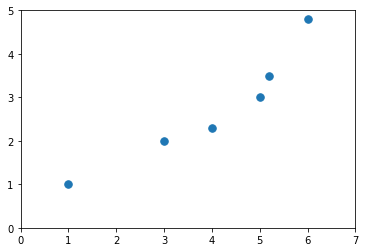

In [3]:
x = np.array([1,3,4,  5,5.2,6])
y = np.array([1,2,2.3,3,3.5,4.8])    
def plot_pts(x,y):
    plt.plot(x,y, '.', markersize=15)
    plt.xlim([0, 7])
    plt.ylim([0, 5])
plot_pts(x,y)

Consider various fits... 

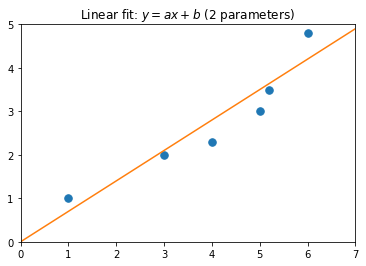

In [4]:
plot_pts(x,y)
grid = np.linspace(0,7,100)
plt.plot(grid,0.7*grid)
plt.title("Linear fit: $y=ax+b$ (2 parameters)")

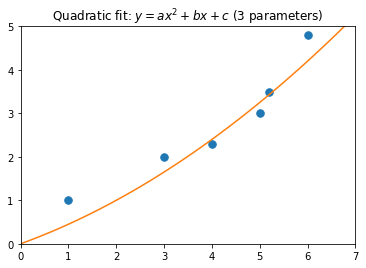

In [5]:
plot_pts(x,y)
plt.plot(grid,0.4*grid+0.05*grid**2)
plt.title("Quadratic fit: $y=ax^2+bx+c$ (3 parameters)")

We can fit various functions from the _polynomial family_. But each polynomial **has a different number of parameters**. Note that the polynomial family always maps from $\mathbb{R}^D\rightarrow \mathbb{R}$.

Model: has parameters that we fit
Family: a set of models that are linked by some theme, but may have different numbers of parameters

- **"Neural network" is a family of functions just like this.**

- There is a motivation behind it, which is that they should "learn the features"

#### Basic set-up

$$ x^{(l+1)} = f\left( W^{(l)} x^{(l)} + b^{(l)}\right) $$

where $W^{(l)}$ is a matrix of parameters, $b^{(l)}$ is a vector of parameters. These are the parameters like the regression coefficients $\beta$ in regression, or the coefficients in the polynomial example above. 

This is a _recurrence relation_ (related to recursion, which we discussed in DSCI 512). 

So what is $x^{(l)}$ ??
 - $x^{(0)}$ are the inputs
 - $x^{(L)}$ are the outputs
 - we refer to $L$ as the number of _layers_



Also: 
 - the $W^{(l)}$ do _not_ need to be square. 
 - the $x^{(l)}$ for $0<l<L$ are "intermediate states"
   - there are called _hidden units_ or _hidden neurons_
   - the _values_ of these units are called _activations_
 - we often refer to the elements of $W$ as "weights" and the elements of $b$ as "biases"
 - we might not apply $f$ at the last layer... more details to come.
 
![](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)

In the diagrams above, circles are states and arrows carry weights.

Important note: neural nets map from $\mathbb{R}^D\rightarrow \mathbb{R}^C$ for some arbitrary $D$ and $C$. The outputs do not have to be scalars. We will make use of this later!

Another note: there are variations on the $Wx$ notation, like $W^\top x$ or $x^\top W$, etc. Let's not get too hung up on this, it's just a matter of convention.

#### unimportant aside: dealing with $b$

Sometimes we get annoyed with $b$ and want to get rid of it. As discussed in DSCI 573, there is a trick to get around this. We define

$$ \tilde{x}^{(l)} \equiv\left[\begin{array}{c}x^{(l)}\\1\\\end{array}\right]$$

and also

$$\tilde{W}^{(l)}\equiv \left[ W^{(l)} \quad b^{(l)} \right] $$

then we have

$$ \tilde{x}^{(l+1)} = f\left( \tilde{W}^{(l)} \tilde{x}^{(l)} \right) $$


The beauty here is that, by making $W$ and $x$ bigger, we eliminate the need to write down $b$. It's just a way of rewriting things more concisely, there isn't really an important concept here...

#### so what about $f$ ?????

 - $f$ is called the _activation function_. 
 - Q: why do we need $f$ at all?
 - A: if no $f$, then we are composing a bunch of linear functions, which just leaves us with a linear function.
 - insight: if $f$ is nonlinear, then increasing the number of "layers" increases the complexity of the overall function. 
 
In neural networks, we choose $f$ to be an _elementwise_ nonlinear function. i.e.

$$f(x)\equiv\left[\begin{array}{c}f(x_1)\\f(x_2)\\ \vdots \\ f(x_D)  \end{array}\right]$$

- Reminder: the weights (elements of the $W^{(l)}$ for $l=1,\ldots,L$) are the parameters to be learned. 
- Note: I won't bother writing $\tilde{W}$ all the time. If there is no $b$, you can assume it's jammed into $W$.

#### some history...

- Artificial neural nets (ANNs) resemble biological neurons in that the hidden units collect inputs (dendrites) and perform a nonlinear operation (threshold: neuron fires or does not fire), and then send the signal along (axons).  
- But, if we used a threshold nonlinearity then the overal function would be _non-differentiable_. So we traditionally pick $f$ to be a "soft threshold" function like the sigmoid (see below)

(-0.1, 1.1)

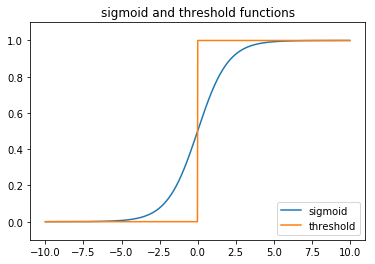

In [6]:
x = np.linspace(-10,10,1000)
f = lambda x: 1/(1+np.exp(-x))
plt.plot(x,f(x))
plt.plot(x,x>0) # also called the Heaviside step function after telecommunications pioneer Oliver Heaviside
plt.legend(("sigmoid", "threshold"),loc="lower right")
plt.title("sigmoid and threshold functions")
plt.ylim(-0.1,1.1)

Sometimes people also use the hyperbolic tangent. It's basically the same thing but has a range of $(-1,1)$ instead of $(0,1)$. 

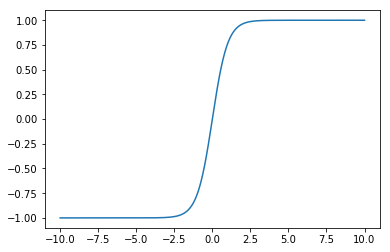

In [7]:
plt.plot(x, np.tanh(x))

More recently, people use the ReLU (Rectified Linear Unit)

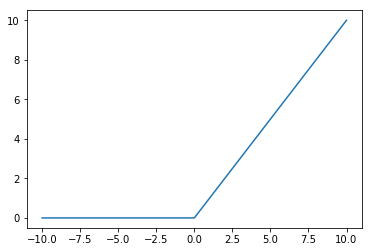

In [8]:
plt.plot(x, np.maximum(0,x))

- This is not differentiable at $x=0$ but we don't worry too much about it. 
- The RELU is nice because it is less sensitive to initialization
  - the sigmoid _saturates_ when $|x|\gg1$

### wonderful... how do we train this thing?

- Say we're doing regression using squared error
- This is a VERY non-convex problem
- Also it's pretty high dimensional
 - OLS in $D$-dimensions: $D+1$ parameters (regression coefficients)
 - NN in $D$-dimensions: umm... it depends...!!!
 
We're back to this notion of a family. We get to decide not only $L$ but also **the size of the intermediate representations** -- i.e., the $x^{(l)}$ for $0<l<L$. This is important! Make sure you understand this. It's a "family" of functions but a big family.

#### notation issue

- It's a matter of taste whether $L$ refers to the total number of layers, or number of hidden layers, or...
- let's say, for our purposes, that $x^{(0)}$ is an input and $x^{(L)}$ is an output, which means we have $L+1$ total layers and $L-1$ hidden layers.

Ok then, we get to pick the dimensionality of each of these representations. Let's call them $D_0,D_1,D_2,\ldots,D_L$. 
 - So $D_0=D$ and $D_L=C$. Just a lot of mess here, but no new concepts.
 
Crucial question: **how many parameters do we have**?

First answer: $$D_0D_1 + D_1D_2 + \ldots + D_{L-1}D_L$$

Almost, but we forgot those pesky biases...

$$(D_0+1)D_1 + (D_1+1)D_2 + \ldots + (D_{L-1}+1)D_L$$

Again, this is just bookkeeping. If it's confusing, just forget about it. But don't forget **this is potentially a lot of parameters!!!!**

e.g. $L=3,D_0=D_1=D_2=D_3=1000$, so we have million of parameters. Sometimes we have billions. So we have a million-dimensional non-convex optimization problem. That's hard. At the very least, we need a gradient.

#### getting the gradient

The least squares loss (a not-uncommon choice for regression) is

$$\mathcal{L}\left(\{W^{(l)}\}\right)= \sum_{i=1}^N \left(y_i - \hat{y}_i\right)^2  $$

Let's digest this...

- by $\{W^{(l)}\}$ I mean the set of all $W$'s and all their elements
- by $\hat{y}_i$ I mean our prediction for example $x_i$, which we get from applying our recurrence relation $L$ times.

We need $$\frac{d\mathcal{L}}{dW}$$

This is done via the chain rule. But we need to be careful not to _recompute_ things (remember dynamic programming?? it was all about not recomputing things). 

We can draw a graph of what depends on what. Consider $\frac{d\mathcal{L}}{dW^{(0)}_{11}}$ and $\frac{d\mathcal{L}}{dW^{(0)}_{12}}$. These two derivates have a lot in commmon, namely...

$$ \frac{d\mathcal{L}}{dx^{(L)}} \frac{dx^{(L)}}{dx^{(L-1)}} \cdots \frac{dx^{(2)}}{dx^{(1)}} \frac{dx^{(1)}}{dW^{(0)}}$$ 

only the last part is different.

- The method for applying the chain rule and not re-computing anything is called **backpropagation** or backprop for short. 
- Backprop is reverse-mode differentiation. So packages like AutoGrad do it "for free"
- Once we have the gradient, we can train with (stochastic) gradient descent. 


In [9]:

"""
A simple neural net implementation with gradient descent (not even SGD), for regression.
"""
class NeuralNet():
    def __init__(self, layer_sizes, learning_rate=0.1, num_epochs=100, init_W_sd=1, activation="tanh"):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_layers = len(layer_sizes)-1
        self.activation = activation
        
        self.W = list()
        for l in range(len(layer_sizes)-1):
            size_in = layer_sizes[l]
            size_out= layer_sizes[l+1]
            self.W.append(init_W_sd/np.sqrt(size_in)*npr.randn(size_in+1, size_out))
        self.W = tuple(self.W) # autograd wants it to be a tuple rather than a list

    def fit(self, X, y):
        objective = lambda W: np.mean((y - self.predict(X, W))**2)
        objective_grad = grad(objective)
        objective_grad(self.W)
        err = list()
        for i in range(self.num_epochs):
            W_grad = objective_grad(self.W)
            for l in range(self.num_layers):
                W_l = self.W[l]
                W_l -= self.learning_rate * W_grad[l]
            err.append(objective(self.W))
        return err # return plot of error versus epochs FYI
        
    def predict(self, X, W=None):
        if W is None:
            W = self.W
        inputs = X
        
        for W_l in W:
            outputs = inputs @ W_l[:-1,:] + W_l[-1]
            inputs = np.tanh(outputs) if self.activation=="tanh" else np.maximum(0, outputs) # ReLU
        return outputs


Training error: 0.000996


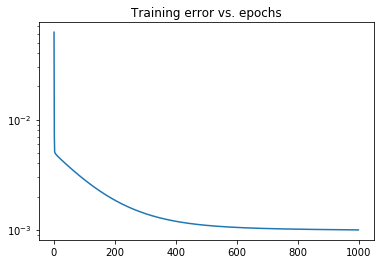

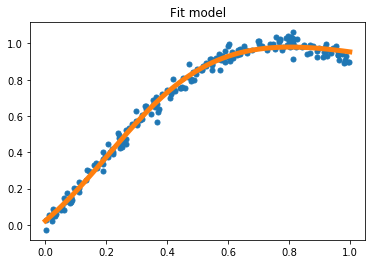

In [10]:

# generate fake data
npr.seed(5)
N = 200
X = npr.rand(N,1)
y = np.sin(2*X) + npr.randn(N,1)*0.03
layer_sizes = [1,10, 1]

NN = NeuralNet(layer_sizes,num_epochs=1000,learning_rate=0.1,init_W_sd=1)
err = NN.fit(X,y)
plt.semilogy(err)
plt.title("Training error vs. epochs")
#NN.predict(X)

plt.figure()
plt.plot(X,y,'.',markersize=10)
grid = np.linspace(0,1,1000)[:,None]
plt.plot(grid, NN.predict(grid),linewidth=5)
plt.title("Fit model")
# list(map(lambda x: x.shape, NN.W))

y_pred = NN.predict(X)
print("Training error: %f" % np.mean((y_pred-y)**2))

#### random weights

To build intuition about the types of functions we can represent, let's explore what happens with random weights using different architectures. Again, this is all within the confines of $\mathbb{R}\rightarrow\mathbb{R}$ which isn't the real deal.


(-10, 10)

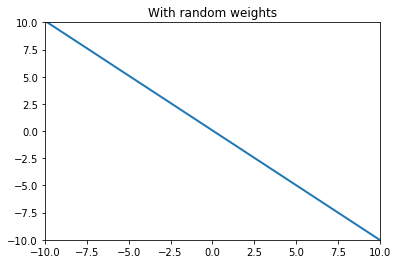

In [11]:
layer_sizes = [1,1]  # no hidden layer... linear regression
# [1,10,1] # with a hidden layer

NN = NeuralNet(layer_sizes,init_W_sd=1)#,activation="relu")

plt.figure()
grid = np.linspace(-10,10,1000)[:,None]
plt.plot(grid, NN.predict(grid),linewidth=2)
plt.title("With random weights")
plt.xlim([-10,10])
plt.ylim([-10,10])

Question: with one hidden layer and the ReLU nonlinearity, with $D=C=1$, what's the maximum number of "kinks" in the function?

Regression example with $D=2$

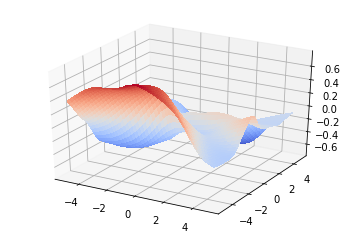

In [12]:

layer_sizes = [2,50,1] 

NN = NeuralNet(layer_sizes,init_W_sd=1)#,activation="relu")
fig = plt.figure()
ax = fig.gca(projection='3d')

n = 100
X = np.linspace(-5, 5, n)
Y = np.linspace(-5, 5, n)
X, Y = np.meshgrid(X, Y)

inputs = np.append(X.flatten()[:,None], Y.flatten()[:,None],axis=1)
outputs = NN.predict(inputs)
Z = np.reshape(outputs, [n,n])

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)


Something harder to visualize: $C>1$ 

## Deep learning software

There's been a lot of software released lately to take care of this for you. Some big players are:

| Name   |  Host language  | Released |  Comments | 
|--------|-------------|---------------|----------|
| [Theano](http://deeplearning.net/software/theano/) | Python | 2007 | From U. de Montréal |
| [Torch](http://torch.ch) | Lua | 2002 | Used at Facebook |
| [PyTorch](http://pytorch.org) | Python | 2017 | Automatic differentiation through arbitrary code like Autograd
| [TensorFlow](https://www.tensorflow.org) | Python | 2015 | Created by Google for both prototyping and production
| [Keras](https://keras.io) | Python | 2015 | A front-end on top of Theano or TensorFlow |
| [Caffe](http://caffe.berkeleyvision.org) | Executable with Python wrapper | 2014 | Specifically for convolution neural nets (see Lecture 7), by UC Berkeley

- There are many others of course. See for example [Comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).
- From the table above, we can see there have been a lot of new packages released recently.
- We will focus on **Keras** as it's very easy to use. 
  - We'll use the TensorFlow backend but the code works for both backends (that's the beauty of it)

#### Repeating the examples above in Keras

In [13]:
from keras.models import Sequential
from keras.layers import Dense
import keras

Using TensorFlow backend.


In [14]:

# generate fake data
npr.seed(5)
N = 200
X = npr.rand(N,1)
y = np.sin(2*X) + npr.randn(N,1)*0.03


In [15]:
model = Sequential()
model.add(Dense(10, input_dim=1, init='lecun_uniform', activation='tanh'))
model.add(Dense(1, init='lecun_uniform', activation='linear'))
# Compile model
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd)#'adam')
# Fit the model
loss=model.evaluate(X, y,verbose=0)
print(loss)
model.fit(X, y, nb_epoch=1000, verbose=0)
# evaluate the model
loss=model.evaluate(X, y,verbose=0)
print(loss)


0.344020814896
0.000931681161746


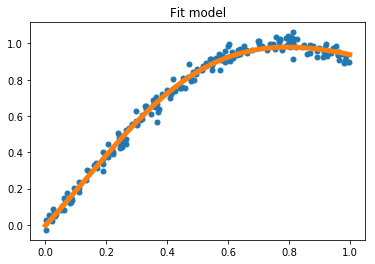

In [16]:

plt.figure()
plt.plot(X,y,'.',markersize=10)
grid = np.linspace(0,1,1000)[:,None]
plt.plot(grid, model.predict(grid),linewidth=5)
plt.title("Fit model")
# list(map(lambda x: x.shape, NN.W))

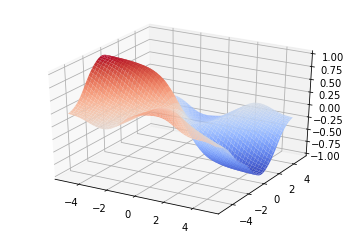

In [20]:
# random weights
model = Sequential()
model.add(Dense(50, input_dim=2, init='lecun_uniform', activation='tanh'))
model.add(Dense(1, init='lecun_uniform', activation='linear'))
model.compile(loss='mean_squared_error', optimizer='sgd')

fig = plt.figure()
ax = fig.gca(projection='3d')

n = 100
X = np.linspace(-5, 5, n)
Y = np.linspace(-5, 5, n)
X, Y = np.meshgrid(X, Y)

inputs = np.append(X.flatten()[:,None], Y.flatten()[:,None],axis=1)
outputs = model.predict(inputs)
Z = np.reshape(outputs, [n,n])

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)
